In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import cross_val_predict, KFold, train_test_split, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import PolynomialFeatures
# import seaborn as sns

import matplotlib
matplotlib.style.use('dark_background')

In [2]:
from os.path import join
import os
os.chdir("..")
proj_dir = os.path.abspath(os.curdir)



In [3]:
new_data_path = join(proj_dir, 'data', "new_data_V2-FE_BULGETEST_SIMULATION_RESULTS.csv")
old_data_path = join(proj_dir, 'data', "fea_tests_2_5_bar_15_08_2021.csv")
exp_data_path = join(proj_dir, 'data', "experiments_v1_CR604M.csv")

In [4]:
def read_data_file(path):
    df = pd.read_csv(path, header=None).T
    df.columns = df.iloc[0]
    df = df.drop(0).reset_index(drop=True)
    df = df.astype('float32')
    return df

In [5]:
def make_tensors(df):
    cols = list(df.columns)
    labels_cols = [col for col in cols if col.startswith('C')]
    height_cols = [col for col in cols if col.startswith('height')]
    pressure_cols = [col for col in cols if col.startswith('pressure')]
    labels = df[labels_cols].values
    pressures = df[pressure_cols].values*1e6 # [kPa]
    heights = df[height_cols].values
    return pressures, heights, labels

In [6]:
df_new_data = read_data_file(new_data_path)
pressures_new, heights_new, labels_new = make_tensors(df_new_data)

In [7]:
df_new_data.describe()

,C1,C2,C3,height1,height2,height3,height4,height5,height6,height7,...,pressure91,pressure92,pressure93,pressure94,pressure95,pressure96,pressure97,pressure98,pressure99,pressure100
count,884.000000,884.000000,8.840000e+02,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,...,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.0000
mean,0.001344,0.000027,1.882872e-07,0.066396,0.273847,0.648316,1.120988,1.666743,2.275238,2.935946,...,0.000273,0.000276,0.000279,0.000282,0.000285,0.000288,0.000291,0.000294,0.000297,0.0003
std,0.000666,0.000014,1.233091e-07,0.007370,0.038388,0.111747,0.224375,0.376867,0.571866,0.812806,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
min,0.000200,0.000003,-4.951000e-08,0.060282,0.218193,0.493488,0.823546,1.179380,1.551960,1.931530,...,0.000273,0.000276,0.000279,0.000282,0.000285,0.000288,0.000291,0.000294,0.000297,0.0003
25%,0.000766,0.000014,8.167750e-08,0.062180,0.243156,0.554324,0.931960,1.349138,1.796662,2.260562,...,0.000273,0.000276,0.000279,0.000282,0.000285,0.000288,0.000291,0.000294,0.000297,0.0003
50%,0.001369,0.000027,1.895000e-07,0.062593,0.265678,0.626556,1.069760,1.572035,2.121225,2.703765,...,0.000273,0.000276,0.000279,0.000282,0.000285,0.000288,0.000291,0.000294,0.000297,0.0003
75%,0.001915,0.000039,2.944000e-07,0.068035,0.294216,0.720463,1.271467,1.916852,2.651913,3.462383,...,0.000273,0.000276,0.000279,0.000282,0.000285,0.000288,0.000291,0.000294,0.000297,0.0003
max,0.002499,0.000050,4.000000e-07,0.090923,0.381258,0.924890,1.659070,2.574480,3.671320,4.955350,...,0.000273,0.000276,0.000279,0.000282,0.000285,0.000288,0.000291,0.000294,0.000297,0.0003


In [8]:
df_old_data = pd.read_csv(old_data_path)
pressures_old, heights_old, labels_old = make_tensors(df_old_data)
pressures_old /= 1e4 # [kPa]

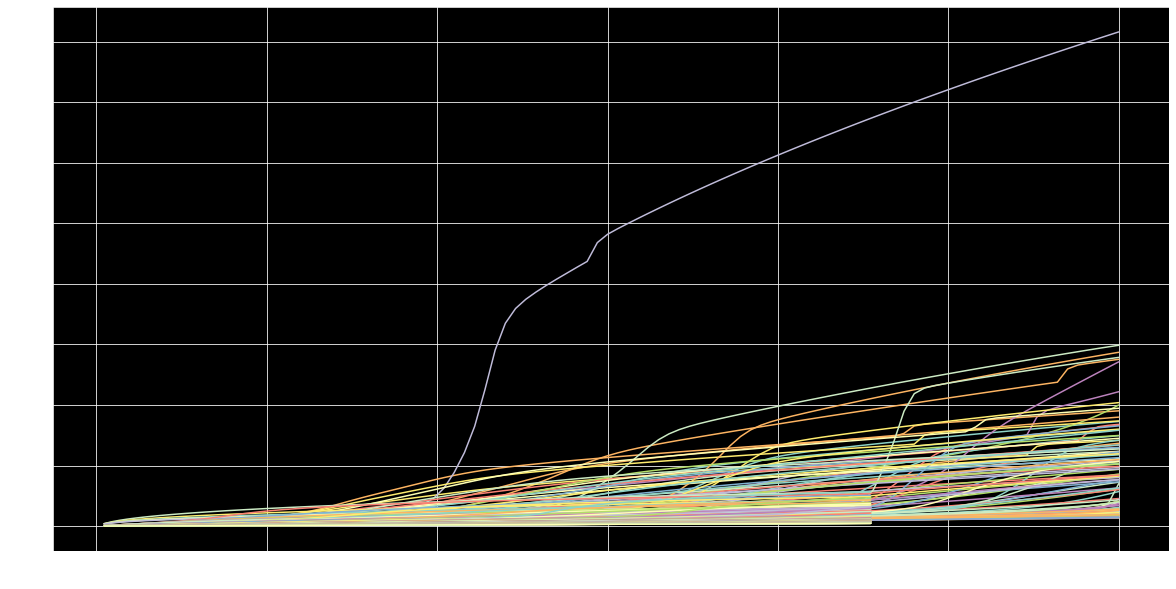

In [9]:
plt.figure(figsize=(20, 10))
pressure_vec_new = pressures_new[0, :]
for ii in range(0, len(df_new_data), 7):
    plt.plot(pressure_vec_new, heights_new[ii, :])
pressure_vec_old = pressures_old[0, :]
for ii in range(0, len(df_old_data), 70):
    plt.plot(pressure_vec_old, heights_old[ii, :])

plt.ylabel('height [mm]')
plt.xlabel('pressure [bar]')
# plt.yscale('log')
plt.show()


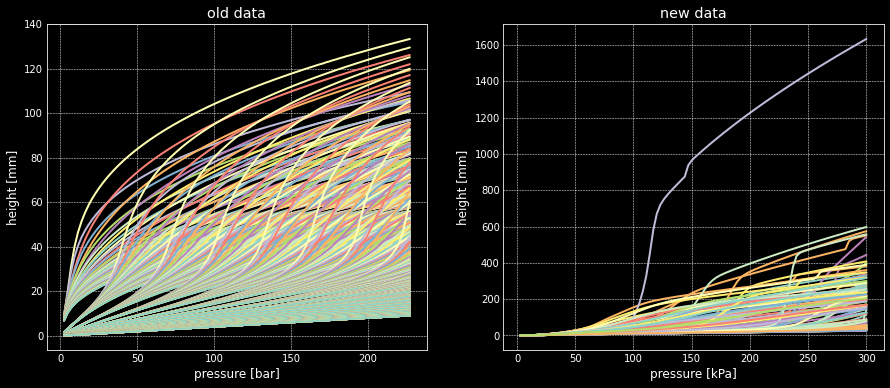

In [13]:

fig, ax = plt.subplots(1,2, figsize=(15,6))
pressure_vec_old = pressures_old[0, :]
for ii in range(0, len(df_old_data), 10):
    ax[0].plot(pressure_vec_old, heights_old[ii, :])
#
ax[0].set_ylabel('height [mm]')
ax[0].set_xlabel('pressure [bar]')
ax[0].set_title('old data')
# plt.yscale('log')

pressure_vec_new = pressures_new[0, :]
for ii in range(0, len(df_new_data), 7):
    ax[1].plot(pressure_vec_new, heights_new[ii, :])
#
ax[1].set_ylabel('height [mm]')
ax[1].set_xlabel('pressure [kPa]')
ax[1].set_title('new data')

# plt.yscale('log')

matplotlib.style.use('dark_background')

plt.show()




In [32]:
pressures_new, heights_new, labels_new = make_tensors(df_new_data)


In [33]:
exp_data = pd.read_csv(exp_data_path, skiprows=1)

In [34]:
def exp_preprocess(exp_data, ii):
    exp = exp_data.iloc[:,ii:ii+2].dropna()
    exp.columns = ['height', 'pressure']
    exp = exp[exp['pressure']>=0]
    exp = exp[exp['height']>=0]
    exp['pressure'] *= 100
    return exp[['pressure', 'height']]

In [35]:
exps = []
for ii in range(0,12,2):
    exps.append(exp_preprocess(exp_data, ii))

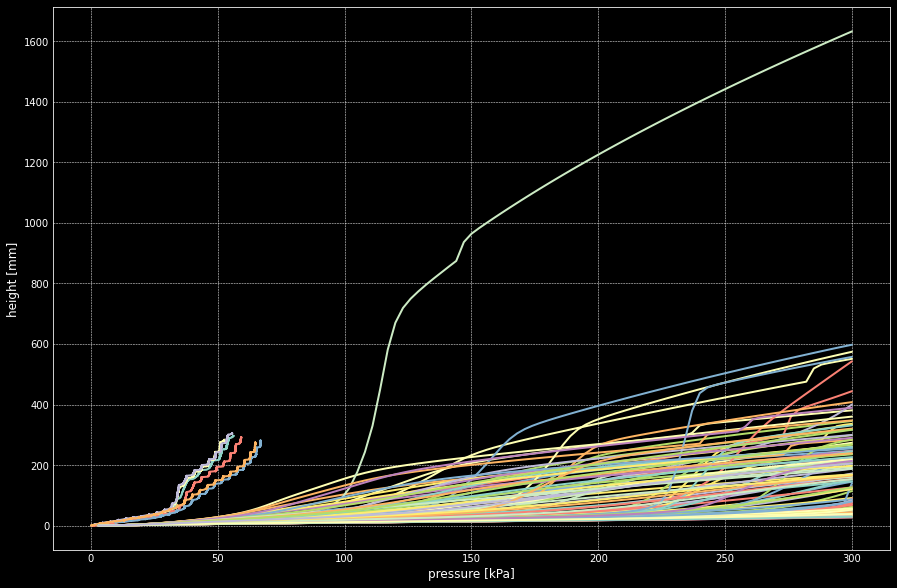

In [36]:
plt.figure(figsize=(15,10))
for ii in range(len(exps)):
    plt.plot(exps[ii]['pressure'], exps[ii]['height'])
plt.ylabel('height [mm]')
plt.xlabel('pressure [kPa]')

pressure_vec_new = pressures_new[0, :]
for ii in range(0, len(df_new_data), 7):
    plt.plot(pressure_vec_new, heights_new[ii, :])

plt.show()


In [10]:
heights_new.max()

1632.71

/tmp/ipykernel_773754/1137770552.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ii].set_xticklabels(ax[ii].get_xticks(), rotation = 45)


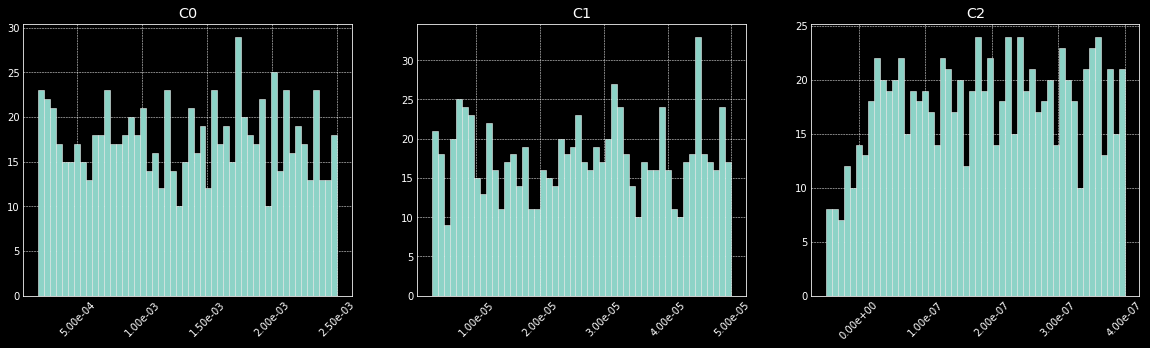

In [30]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for ii in range(3):
    ax[ii].hist(labels_new[:,ii], bins=50); ax[ii].set_title(f'C{ii}')
    ax[ii].set_xticklabels(ax[ii].get_xticks(), rotation = 45)
    ax[ii].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))

/tmp/ipykernel_773754/2099874203.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ii].set_xticklabels(ax[ii].get_xticks(), rotation = 45)


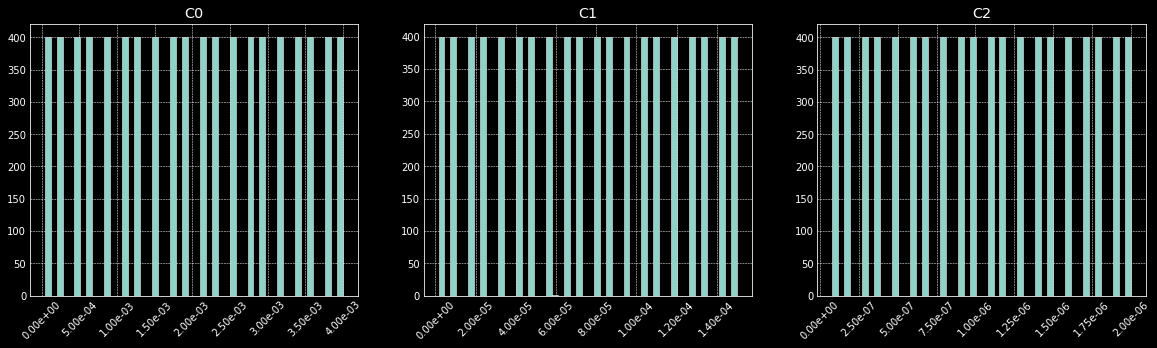

In [28]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for ii in range(3):
    ax[ii].hist(labels_old[:,ii], bins=50); ax[ii].set_title(f'C{ii}');
    ax[ii].set_xticklabels(ax[ii].get_xticks(), rotation = 45)
    ax[ii].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))